## Neural Network classification with PyTorch

### 1. Make classification data and get it ready

In [32]:
import torch
from torch import nn
import numpy as np
import sklearn

In [33]:
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [34]:
len(X), len(y)

(1000, 1000)

In [35]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of X: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of X: [1 1 1 1 0]


In [36]:
X[0,0]

0.7542462506997276

In [37]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


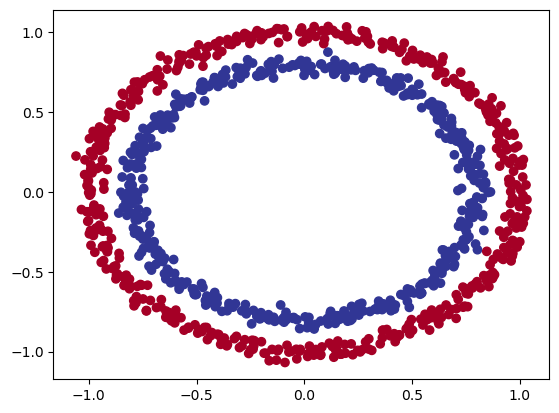

In [38]:
# Let's visualize it
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note that tthe data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals.

## 1.1 Check input and output shapes



In [39]:
X.shape, y.shape

((1000, 2), (1000,))

In [40]:
# View the first example of the features and labels
X_sample =  X[0]
y_sample = y[0]
print(f"Value for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Value for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [41]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [42]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [43]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, #20% will be test and the rest will be train
                                                    random_state=42)

In [44]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Lets build a model to classify our blue and red dots.

To do so we want to:
1. Setup device agnostic code
2. Construct a model
  * subclass `nn.Module`
  * Create two `nn.Linear` layers that are capable of handling the shapes of out data
  * Define a forward method that oulines the forward pass or forward computation of the model
  * We want to instantiate an instance of our model class and send it to our device
3. Define a loss function and optimizer
4. Create a training and testing loop

In [45]:
# 1
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [46]:
# 2
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2.2 Create two nn.Linear layers that are capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [47]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [48]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2,
              out_features=5),
    nn.Linear(in_features=5,
              out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [49]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [50]:
# Make some predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f'Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}')
  print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
  print(f'\nFirst 10 predictions: {untrained_preds[:10]}')
  print(f'\nFirst 10 labels: {y_train[:10]}')

Length of predictions: 200, shape: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions: tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

First 10 labels: tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should we use here?(for this specific problem)
For example for regression we might want to use MAE or MSE

For classification we might want binary cross entropy or categorical cross entropy.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has a lot of options.

* For the loss function we are going to use `torch.nn.BCEWithLogitsLoss()`.

In [51]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [52]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### 3. Train model

To train our model, we are going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero
4. Loss backward (Backprop)
5. Optimizer step (Gradient descent)

## 3.1  Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of acivation function (e.g. sigmoid for binary crossentropy and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them (this is for binary classification) or taking the `argmax()` (this is for the outputs of softmax activation function).

In [53]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [54]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [55]:
# Use the sigomid activation function on our binary logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736],
        [0.5737],
        [0.5351],
        [0.5542],
        [0.5201],
        [0.4929],
        [0.4843],
        [0.4948],
        [0.5460],
        [0.5366],
        [0.5131],
        [0.5577],
        [0.5150],
        [0.4807],
        [0.4913],
        [0.4863],
        [0.4911],
        [0.5710],
        [0.4929],
        [0.4797],
        [0.5203],
        [0.5438],
        [0.5631],
        [0.5785],
        [0.5104],
        [0.5440],
        [0.5306],
        [0.5162],
        [0.4836],
        [0.5663],
        [0.4808],
        [0.5028],
        [0.4891],
        [0.5324],
        [0.5614],
        [0.5403],
        [0.4927],
        [0.5120],
        [0.5167],
        [0.5799],
        [0.4812],
        [0.5047],
        [0.5793],
        [0.4887],
        [0.5025],
        [0.5736],
        [0.4828],
        [0.4803],
        [0.5744],
        [0.5779],
        [0.5426],
        [0

For our prediction probability values, we need to preform a range-style rounding on them.

In [56]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)[:5]
# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
# Get rid of extra dimension once again
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

In [57]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [58]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

epochs = 100
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits into pred probs into pred labels
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69796, Acc: 51.88% | Test Loss: 0.69440, Test Acc: 58.00%
Epoch: 10 | Loss: 0.69590, Acc: 51.25% | Test Loss: 0.69305, Test Acc: 53.00%
Epoch: 20 | Loss: 0.69490, Acc: 51.62% | Test Loss: 0.69254, Test Acc: 49.50%
Epoch: 30 | Loss: 0.69435, Acc: 51.12% | Test Loss: 0.69236, Test Acc: 49.50%
Epoch: 40 | Loss: 0.69401, Acc: 50.88% | Test Loss: 0.69232, Test Acc: 51.00%
Epoch: 50 | Loss: 0.69378, Acc: 50.25% | Test Loss: 0.69234, Test Acc: 50.00%
Epoch: 60 | Loss: 0.69362, Acc: 50.00% | Test Loss: 0.69239, Test Acc: 51.50%
Epoch: 70 | Loss: 0.69351, Acc: 50.25% | Test Loss: 0.69246, Test Acc: 51.00%
Epoch: 80 | Loss: 0.69342, Acc: 49.88% | Test Loss: 0.69254, Test Acc: 50.00%
Epoch: 90 | Loss: 0.69336, Acc: 49.88% | Test Loss: 0.69262, Test Acc: 53.00%


## 4. Make predictions and evaluate the model

From the metrics we can see that our model isnt really learning anything.

So to inspect it let's make some predictions and make them visual.

To do so, we're going to import a fn called `plot_decision_boundary()`



In [59]:
import requests
from pathlib import Path
#Download helper functions from learn pytorch repo (if it's not already downloaded
if Path ("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


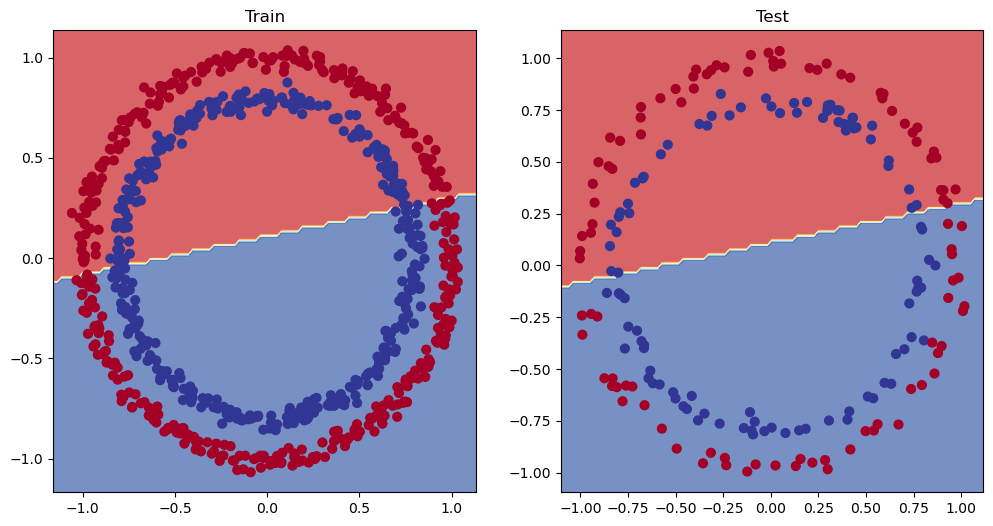

In [60]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # Row, column, index
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


## 5. Imporving a model (from a model perspective)
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units
* Fit for longer (Increase the number of epochs)
* Changing the activation functions
* Change the learning rate (If it'ss too small it wont learn anything or it's too high it might explode)
* Change the loss function

These options are all from a model's perspective because they deal directly with the model rather than the data.

And because these options are all values we can change they are referred to as **hyperparams**

In [62]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=10)
        self.layer_2 = nn.Linear(in_features=10,
                                 out_features=10)
        self.layer_3 = nn.Linear(in_features=10,
                                 out_features=1 )
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)